In [1]:
#!pip install librosa
#!pip install ffmpeg

#!pip install numba==0.48
#!pip install librosa==0.7.2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
%matplotlib inline
from PIL import Image
import os
import shutil
from numpy import asarray
import random
import utils



In [3]:
fma_small = pd.read_csv("data/fma_small.csv")
fma_small.shape
fma_small

,Song ID,Song Title,Genre,Artist ID,Artist Name,Set,Path
0,2,Food,Hip-Hop,1,AWOL,training,training/Hip-Hop/2.png
1,5,This World,Hip-Hop,1,AWOL,training,training/Hip-Hop/5.png
2,10,Freeway,Pop,6,Kurt Vile,training,training/Pop/10.png
3,140,Queen Of The Wires,Folk,54,Alec K. Redfearn & the Eyesores,training,training/Folk/140.png
4,141,Ohio,Folk,54,Alec K. Redfearn & the Eyesores,training,training/Folk/141.png
...,...,...,...,...,...,...,...
7899,154308,MIA,Hip-Hop,23208,Fleslit,test,test/Hip-Hop/154308.png
7900,154309,A1 Symphony,Hip-Hop,23208,Fleslit,test,test/Hip-Hop/154309.png
7901,154413,Do Easy,Pop,24252,Tasseomancy,training,training/Pop/154413.png
7902,154414,Dead Can Dance (uncensored),Pop,24252,Tasseomancy,training,training/Pop/154414.png


In [4]:
#AUDIO_FILE = "Data/fma_small/000/000993.mp3"

def MP3ToSpectrogram(AUDIO_FILE, file_Name):
    signal, sr = librosa.load(AUDIO_FILE)

    # this is the number of samples in a window per fft
    n_fft = 2048

    # The amount of samples we are shifting after each fft
    hop_length = 512

    mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(power_to_db, sr=sr, cmap="magma", hop_length=hop_length) # x_axis="time", y_axis="mel"
    plt.savefig("SpectrogramData/"+file_Name+".png", bbox_inches="tight")

#MP3ToSpectrogram("Data/fma_small/013/013378.mp3", "Test1")
#img = Image.open("Test1"+".png")

We utilize the librosa library [12] to load audio tracks and extract random clips
of 524288 samples (219) during each training iteration.
This strategy serves two purposes.
Firstly, using the entire signal length as input can significantly increase
computational costs and impact the design of the architectures, particularly
for 1-D models. Secondly, the random subsampling acts as a form of time-shift
data augmentation, allowing the models to recognize the genre of a musical piece
regardless of the exact starting point of the clip.

In [19]:
seed = 12345
random.seed(seed)
np.random.seed(seed)
import imageio

def load_audio(path):
    try:
        y, sr = librosa.load(path, sr=None, mono=True)
        min_duration = 25
        # Calculate the duration of the audio file in seconds
        duration = len(y) / sr

        # Check if the duration is less than the minimum required duration
        if duration < min_duration:
            print(path)
            print(f"Audio file is shorter than the minimum required duration of {min_duration} seconds.")
        else:
            # select only 2**19 samples at random (behave like a audio.Shift transform)
            start = np.random.randint(0, y.shape[0]-2**19)
            y = y[start:start+2**19]

            return y, sr
        
    except Exception as e:
        print(f"Error: An error occurred while loading audio file {path}. Error message: {e}")
        return None, None
    
##########################################

def create_mel_spectrogram(path, fileID, error_count):
    # load audio
    y, sr = load_audio(path)
    if y is None or sr is None:
        return None
    
    # create lin-power mel spectrogram (discard last time bin)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=1024, n_mels=128)[:,:512]
    # create log-power mel spectrogram
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
#    print(spectrogram.shape)
    save_spectrogram(spectrogram, fileID, error_count)
    
    return y, spectrogram, sr


def save_spectrogram(spectrogram, fileID, error_count):
    matched_row = fma_small[fma_small["Song ID"] == fileID]
    
    # Calculate figure size needed to match 128x512 data points at a given DPI
    dpi = 10  # You can adjust this as needed
    fig_width = 512 / dpi  # Width in inches to match 512 pixels at the given DPI
    fig_height = 128 / dpi  # Height in inches to match 128 pixels at the given DPI

    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    
    if len(matched_row) == 1:
        set_value, genre, song_id = matched_row[["Set", "Genre", "Song ID"]].iloc[0].astype(str)
        final_path = f"NewSpectrogramData/{set_value}/{genre}/{song_id}.png"

        # Plot the spectrogram
        plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='plasma')

        plt.axis('off')  # Hide the axes
        plt.tight_layout()

        # Save the plotted figure
        plt.savefig(final_path, bbox_inches="tight")
        plt.close()  # Close the figure to free memory
        
    elif len(matched_row) > 1:
        #print(f"ERROR MATCHING {fileID}"+" TO MANY MATCHES")
        tmp = 1
    elif len(matched_row) == 0:
        error_count += 1
        #print(f"ERROR MATCHING {fileID}"+" 0 MATCHES")
    
    


def plot_mel_spectrogram(path):

    # get log-power mel spectrogram and sampling rate
    _, spectrogram, sr = create_mel_spectrogram(path, 4778)

    fig, ax = plt.subplots(figsize=(10,6))

    img = librosa.display.specshow(spectrogram, sr=sr, hop_length=1024, x_axis='time', y_axis='mel', ax=ax)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.xlabel('Time [s]', fontsize=18)
    plt.ylabel('Frequency [Hz]', fontsize=18)
    #plt.title(f'Log-power mel-spectrogram\ntrack id = {track_id} : genre = {genre}', fontsize=20)

    cbar = plt.colorbar(img)
    cbar.ax.set_ylim(-80, 0)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('dB', size=18)

    #plt.savefig('./images/Spectrogram.pdf', dpi=1200, bbox_inches='tight')
    plt.show()



In [20]:
create_mel_spectrogram("Data/fma_small/004/004778.mp3", 4778, 0)

(array([-0.07755621, -0.03318416,  0.02010757, ..., -0.01649958,
        -0.02468019, -0.04666156], dtype=float32),
 array([[-38.423046 , -21.995298 , -14.615835 , ..., -15.060917 ,
         -14.27486  , -17.888231 ],
        [-27.508547 , -15.32662  ,  -8.750423 , ...,  -6.636223 ,
          -6.238207 , -10.655884 ],
        [-24.659506 , -14.475069 ,  -6.760723 , ...,  -3.4636574,
          -4.6414585, -10.51004  ],
        ...,
        [-69.88977  , -75.91624  , -80.       , ..., -80.       ,
         -80.       , -80.       ],
        [-69.93348  , -75.95982  , -80.       , ..., -80.       ,
         -80.       , -80.       ],
        [-69.963585 , -75.9899   , -80.       , ..., -80.       ,
         -80.       , -80.       ]], dtype=float32),
 44100)

(128, 512)


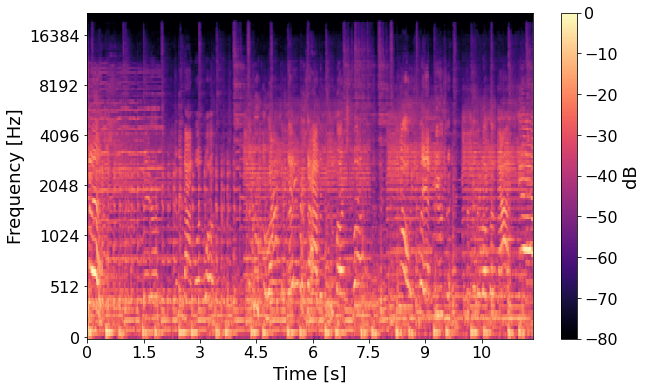

In [13]:
plot_mel_spectrogram("Data/fma_small/004/004778.mp3")

In [21]:
error_count = 0

def convert_all_files_to_spectrogram(error_count):
    progress = 0
    MelSpectrograms = []
    directory = "Data/fma_small"

    # Create SpectrogramData directory if it does not exist
    if not os.path.exists("SpectrogramData"):
        os.makedirs("SpectrogramData")

    # Iterate over files in the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            fileID = int(filename[:-4]) # Remvoes .MP3 prefix
            filePath = os.path.join(root, filename)
            #MP3ToSpectrogram(filePath, str(fileID))
            create_mel_spectrogram(filePath, fileID, error_count)
            progress += 1
            if progress%100 == 0:
                print("Progress:",progress/fma_small.shape[0])

convert_all_files_to_spectrogram(error_count)

Progress: 0.012651821862348178
Progress: 0.025303643724696356
Progress: 0.03795546558704453
Progress: 0.05060728744939271
Progress: 0.06325910931174089
Progress: 0.07591093117408906
Progress: 0.08856275303643725
Progress: 0.10121457489878542
Progress: 0.11386639676113361
Progress: 0.12651821862348178
Progress: 0.13917004048582995
Progress: 0.15182186234817813
Progress: 0.16447368421052633
Progress: 0.1771255060728745
Progress: 0.18977732793522267
Progress: 0.20242914979757085


C:\Users\Jespe\AppData\Local\Temp\ipykernel_12236\3909241871.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
C:\Users\Jespe\AppData\Local\Temp\ipykernel_12236\3909241871.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(fig_width, fig_height), dpi=dpi)


Progress: 0.21508097165991902
Progress: 0.22773279352226722
Progress: 0.2403846153846154
Progress: 0.25303643724696356
Progress: 0.26568825910931176
Progress: 0.2783400809716599
Progress: 0.2909919028340081
Progress: 0.30364372469635625
Progress: 0.31629554655870445
Progress: 0.32894736842105265
Progress: 0.3415991902834008
Progress: 0.354251012145749
Progress: 0.36690283400809715
Progress: 0.37955465587044535
Progress: 0.39220647773279355
Progress: 0.4048582995951417
Progress: 0.4175101214574899
Progress: 0.43016194331983804
Progress: 0.44281376518218624
Progress: 0.45546558704453444
Progress: 0.4681174089068826
Progress: 0.4807692307692308
Progress: 0.4934210526315789
Progress: 0.5060728744939271
Progress: 0.5187246963562753
Progress: 0.5313765182186235
Progress: 0.5440283400809717
Progress: 0.5566801619433198


C:\Users\Jespe\AppData\Local\Temp\ipykernel_12236\3909241871.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, mono=True)
C:\Users\Jespe\Anaconda3\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error: An error occurred while loading audio file Data/fma_small\098\098565.mp3. Error message: 
Error: An error occurred while loading audio file Data/fma_small\098\098567.mp3. Error message: 
Error: An error occurred while loading audio file Data/fma_small\098\098569.mp3. Error message: 


C:\Users\Jespe\AppData\Local\Temp\ipykernel_12236\3909241871.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, mono=True)
C:\Users\Jespe\Anaconda3\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error: An error occurred while loading audio file Data/fma_small\099\099134.mp3. Error message: 
Progress: 0.569331983805668
Progress: 0.5819838056680162
Progress: 0.5946356275303644
Progress: 0.6072874493927125
Progress: 0.6199392712550608


C:\Users\Jespe\AppData\Local\Temp\ipykernel_12236\3909241871.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, mono=True)
C:\Users\Jespe\Anaconda3\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error: An error occurred while loading audio file Data/fma_small\108\108925.mp3. Error message: 
Progress: 0.6325910931174089
Progress: 0.645242914979757
Progress: 0.6578947368421053
Progress: 0.6705465587044535
Progress: 0.6831983805668016
Progress: 0.6958502024291497
Progress: 0.708502024291498
Progress: 0.7211538461538461
Progress: 0.7338056680161943
Progress: 0.7464574898785425
Progress: 0.7591093117408907
Progress: 0.7717611336032388
Progress: 0.7844129554655871
Progress: 0.7970647773279352
Progress: 0.8097165991902834
Progress: 0.8223684210526315
Progress: 0.8350202429149798
Progress: 0.8476720647773279
Progress: 0.8603238866396761
Progress: 0.8729757085020243


C:\Users\Jespe\AppData\Local\Temp\ipykernel_12236\3909241871.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, mono=True)
C:\Users\Jespe\Anaconda3\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error: An error occurred while loading audio file Data/fma_small\133\133297.mp3. Error message: 
Progress: 0.8856275303643725
Progress: 0.8982793522267206
Progress: 0.9109311740890689
Progress: 0.923582995951417
Progress: 0.9362348178137652
Progress: 0.9488866396761133
Progress: 0.9615384615384616
Progress: 0.9741902834008097
Progress: 0.9868421052631579
Progress: 0.9994939271255061
Progress: 1.0121457489878543


<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

<Figure size 512x128 with 0 Axes>

In [16]:
error_count

0

In [ ]:
# Remove the files that were filtered out earliere
# Should have a folder with 7904 spectrograms now and a CSV file with the corresponding metadata
filenames_to_keep = list(fma_small["ID"])

for filename in os.listdir("SpectrogramData"):
    file_path = os.path.join(directory, filename)
    fileID = int(filename[:-4]) # Since the ID's only include the int and not .mp3 I remove this part in every name.
    if os.path.isfile(file_path) and fileID not in filenames_to_keep:
#        print(int(filename[:-4]))
        os.remove(file_path)
    else:
        filename = normalize_image(filename)
